In [1]:
pip install tifffile

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tifffile import imread
from PIL import Image
from google.colab.patches import cv2_imshow
import random
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
data_path = "/content/drive/MyDrive/Sentinel/"
checkpoint_path = '/content/drive/MyDrive/Satellite_image_segmenattion/Checkpoints/unet_multispectral_segmentation.pth.tar'
results_image_path = '/content/drive/MyDrive/Satellite_image_segmenattion/saved_images/multispectral_images/'
images_path = data_path + "images"
labels_path = data_path + "labels"
images_id = [f.name for f in os.scandir(images_path)]

## **Visualization of a Multi Spectral Image along with its corresponding mask.**

In [24]:
def read_image(images_path,labels_path,id):
  image = os.path.join(images_path,images_id[id],"07.tif")
  label = os.path.join(labels_path,images_id[id],"dlt.tif")
  img = imread(image)
  label = imread(label)
  return img,label

def rgb_image_preprocessing(img):
  rgb_image = img[:,:,[2,1,0]]
  rgb_image = np.int16(rgb_image)
  rgb_image = np.clip(rgb_image,0,1500)
  rgb_image = rgb_image/1500 * 255
  rgb_image = np.float32(rgb_image)
  return rgb_image

def multispectral_image_preprocessing(img):
  rgb_image = img[:,:,:]
  rgb_image = np.int16(rgb_image)
  rgb_image = np.clip(rgb_image,0,1500)
  rgb_image = rgb_image/1500 * 255
  rgb_image = np.float32(rgb_image)
  return rgb_image
  
def labelVisualize(num_class, color_dict, img):
  img = img[:,:,0] if len(img.shape) == 3 else img
  img_out = np.zeros((64, 64, 3))
  for i in range(num_class):
      img_out[img == i,:] = np.asarray(color_dict[i])
  return img_out

color_dict = {
    0: [255, 0, 0],
    1: [0, 255, 0],
    2: [0, 0, 255],
}


In [25]:
# visualization on 1 sample image
image,label = read_image(images_path,labels_path,id=20)
num_classes = len(np.unique(label))  # No of classes for segmentation
rgb_image = rgb_image_preprocessing(image)
mulitspectral_image = multispectral_image_preprocessing(image)

# visualization on 2 sample image
image1,label1 = read_image(images_path,labels_path,id=5)
rgb_image_01 = rgb_image_preprocessing(image1)


Image


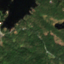

Label


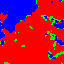

----------------------
Image


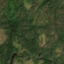

Label


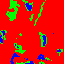

In [26]:
label = labelVisualize(num_classes,color_dict,label)
label_01 = labelVisualize(num_classes,color_dict,label1)
print("Image")
cv2_imshow(rgb_image)
print("Label")
cv2_imshow(label)
print("----------------------")
print("Image")
cv2_imshow(rgb_image_01)
print("Label")
cv2_imshow(label_01)

**Next shuffle and split the images in train(70%), val(20%), test(10%). I have stored the id's of the image in 3 seperate file.**


In [27]:
if os.path.exists('/content/drive/MyDrive/Sentinel/train.txt'):
  print("Train split file already exist")
else:
  random.shuffle(images_id)
  train_image_id = images_id[0:3960]
  with open("/content/drive/MyDrive/Sentinel/train.txt", "w") as f:
    for train_item in train_image_id:
        f.write("%s\n" % train_item)

if os.path.exists('/content/drive/MyDrive/Sentinel/val.txt'):
  print("Val split file already exist")
else:
  val_image_id = images_id[3960:5052]
  with open("/content/drive/MyDrive/Sentinel/val.txt", "w") as f:
      for val_item in val_image_id:
          f.write("%s\n" % val_item)

if os.path.exists('/content/drive/MyDrive/Sentinel/test.txt'):
  print("Test split file already exist")
else:
  test_image_id = images_id[5052:]
  with open("/content/drive/MyDrive/Sentinel/test.txt", "w") as f:
      for test_item in test_image_id:
          f.write("%s\n" % test_item)


with open("/content/drive/MyDrive/Sentinel/train.txt", "r") as f:
    train_idx = [idx.rstrip() for idx in f]
with open("/content/drive/MyDrive/Sentinel/val.txt", "r") as f:
    val_idx = [idx.rstrip() for idx in f]
with open("/content/drive/MyDrive/Sentinel/test.txt", "r") as f:
    test_idx = [idx.rstrip() for idx in f]


Train split file already exist
Val split file already exist
Test split file already exist


In [28]:
class Segmentation_Dataset(Dataset):
    """ Image sedmenattion."""

    def __init__(self, data_path, images_ids):
        self.images_path = data_path + "images"
        self.labels_path = data_path + "labels"
        self.images_ids = images_ids

    def __len__(self):
        return len(self.images_ids)

    def __getitem__(self, idx):
        image = os.path.join(self.images_path,self.images_ids[idx],"07.tif")
        label = os.path.join(self.labels_path,self.images_ids[idx],"dlt.tif")
        image = imread(image)
        label = imread(label)
        label[label==255]=0
        # Data Preprocesing for multi spectral images
        multi_spectral_image = np.transpose(image[:,:,:])
        multi_spectral_image = np.int16(multi_spectral_image)
        multi_spectral_image = np.clip(multi_spectral_image,0,2000)
        multi_spectral_image = multi_spectral_image/2000 * 255
        multi_spectral_image = np.float32(multi_spectral_image)

        rgb_image = rgb_image_preprocessing(image)

        multi_spectral_image = torch.tensor(multi_spectral_image)
        label = torch.tensor(label)
        return multi_spectral_image,label,rgb_image

In [29]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand


In [30]:
unet = UNET(12,num_classes).cuda()

In [31]:
train_dataset = Segmentation_Dataset(data_path, train_idx)
val_dataset = Segmentation_Dataset(data_path, val_idx)
test_dataset = Segmentation_Dataset(data_path, test_idx)

train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

loss_function = nn.CrossEntropyLoss()

In [32]:
def train(model, dataloader, epochs, optimizer, loss_fn, device = "cuda"):
  model.train()
  train_running_loss = 0.0
  for iter,(image,label) in enumerate(dataloader):
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()

    output = model(image)
    loss = loss_function(output,label.long())
    if iter%100 == 0:
      print("Train epochs: "+str(epochs)+" Iteration: "+str(iter)+" loss: "+str(loss.item()))

    train_running_loss += loss.item()
    loss.backward()
    optimizer.step()
  
  return train_running_loss/len(dataloader)

def val(model, dataloader, epochs, loss_fn, device = "cuda"):
  model.eval()
  val_running_loss = 0.0
  for iter,(image,label) in enumerate(dataloader):
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    loss = loss_function(output,label.long())
    if iter%100 == 0:
      print("Val epochs: "+str(epochs)+" Iteration: "+str(iter)+" loss: "+str(loss.item()))

    val_running_loss += loss.item()

  return val_running_loss/len(dataloader)



In [28]:
num_of_epochs = 10
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
min_loss = np.inf
for epoch in tqdm(range(num_of_epochs)):
  train_loss = train(unet, train_dl, epoch, optimizer, loss_function, device="cuda")
  val_loss = val(unet, val_dl, epoch, loss_function, device="cuda")
  # writer.add_scalar("Loss/train", train_loss, epoch)
  # writer.add_scalar("Loss/val", val_loss, epoch)
  
  if (val_loss < min_loss):
    min_loss = val_loss
    checkpoint = {
        "model" : unet.state_dict(),
        "Val Loss" : val_loss
    }
    torch.save(checkpoint,"/content/drive/MyDrive/Satellite_image_segmenattion/Checkpoints/unet_multispectral_segmentation.pth.tar")


  0%|          | 0/10 [00:00<?, ?it/s]

Train epochs: 0 Iteration: 0 loss: 0.7001374363899231
Train epochs: 0 Iteration: 100 loss: 0.6869183778762817
Train epochs: 0 Iteration: 200 loss: 0.6889840960502625
Val epochs: 0 Iteration: 0 loss: 0.7887331247329712



 10%|█         | 1/10 [15:00<2:15:01, 900.13s/it]

Train epochs: 1 Iteration: 0 loss: 0.6126732230186462
Train epochs: 1 Iteration: 100 loss: 0.4847978949546814
Train epochs: 1 Iteration: 200 loss: 0.555462121963501
Val epochs: 1 Iteration: 0 loss: 0.7173359394073486



 20%|██        | 2/10 [15:35<1:25:25, 640.66s/it]

Train epochs: 2 Iteration: 0 loss: 0.6752840280532837
Train epochs: 2 Iteration: 100 loss: 0.7694860100746155
Train epochs: 2 Iteration: 200 loss: 0.5169468522071838
Val epochs: 2 Iteration: 0 loss: 0.8810540437698364



 30%|███       | 3/10 [16:07<53:26, 458.03s/it]  

Train epochs: 3 Iteration: 0 loss: 0.48673921823501587
Train epochs: 3 Iteration: 100 loss: 0.439312219619751
Train epochs: 3 Iteration: 200 loss: 0.47325819730758667
Val epochs: 3 Iteration: 0 loss: 0.7878968119621277



 40%|████      | 4/10 [16:38<33:00, 330.07s/it]

Train epochs: 4 Iteration: 0 loss: 0.49590545892715454
Train epochs: 4 Iteration: 100 loss: 0.5909068584442139
Train epochs: 4 Iteration: 200 loss: 0.5030215382575989
Val epochs: 4 Iteration: 0 loss: 1.3106498718261719



 50%|█████     | 5/10 [17:10<20:02, 240.53s/it]

Train epochs: 5 Iteration: 0 loss: 0.6246559619903564
Train epochs: 5 Iteration: 100 loss: 0.4600304365158081
Train epochs: 5 Iteration: 200 loss: 0.5973318815231323
Val epochs: 5 Iteration: 0 loss: 0.7210031151771545



 60%|██████    | 6/10 [17:41<11:51, 177.83s/it]

Train epochs: 6 Iteration: 0 loss: 0.6589241623878479
Train epochs: 6 Iteration: 100 loss: 0.4849860370159149
Train epochs: 6 Iteration: 200 loss: 0.39225056767463684
Val epochs: 6 Iteration: 0 loss: 1.0297205448150635



 70%|███████   | 7/10 [18:13<06:41, 133.94s/it]

Train epochs: 7 Iteration: 0 loss: 0.4919217824935913
Train epochs: 7 Iteration: 100 loss: 0.3637803792953491
Train epochs: 7 Iteration: 200 loss: 0.5066425800323486
Val epochs: 7 Iteration: 0 loss: 0.5763714909553528



 80%|████████  | 8/10 [18:44<03:26, 103.20s/it]

Train epochs: 8 Iteration: 0 loss: 0.5371543169021606
Train epochs: 8 Iteration: 100 loss: 0.45288604497909546
Train epochs: 8 Iteration: 200 loss: 0.43352967500686646
Val epochs: 8 Iteration: 0 loss: 0.6014165282249451



 90%|█████████ | 9/10 [19:16<01:21, 81.66s/it] 

Train epochs: 9 Iteration: 0 loss: 0.38694700598716736
Train epochs: 9 Iteration: 100 loss: 0.6187266111373901
Train epochs: 9 Iteration: 200 loss: 0.3343122601509094
Val epochs: 9 Iteration: 0 loss: 1.1201841831207275



100%|██████████| 10/10 [19:47<00:00, 118.79s/it]


In [33]:
# Load RGB model
def Load_model(model_dir):  
  checkpoint = torch.load(model_dir)
  model = unet
  model.load_state_dict(checkpoint['model'])
  model = model.to(device="cuda")
  model.eval()
  return model

In [34]:
def one_hot_encoding(label):
    labels = [0, 1, 2]
    semantics = []
    for colour in labels:
        equality = np.equal(label, colour)
        semantics.append(equality)
    semantics = np.stack(semantics, axis=-1)
    return semantics

def accuracy(outputs, labels):
    tp = torch.sum(torch.logical_and(labels, outputs))
    tn = torch.numel(outputs) - torch.sum(torch.logical_or(labels, outputs))
    acc = (tp + tn) / torch.numel(outputs)
    return acc

def iou_matrix(outputs, labels):
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou = (torch.sum(intersection) + SMOOTH) / (torch.sum(union)+ SMOOTH)
    return iou

Multi spectral image label


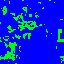

Multi spectral Network Output


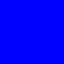

---------------------------
Multi spectral image label


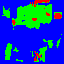

Multi spectral Network Output


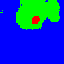

---------------------------
Multi spectral image label


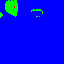

Multi spectral Network Output


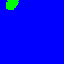

---------------------------
Multi spectral image label


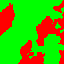

Multi spectral Network Output


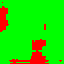

---------------------------
Multi spectral image label


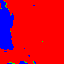

Multi spectral Network Output


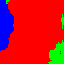

---------------------------
Multi spectral image label


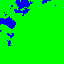

Multi spectral Network Output


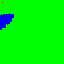

---------------------------
Multi spectral image label


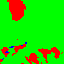

Multi spectral Network Output


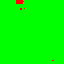

---------------------------
Multi spectral image label


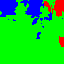

Multi spectral Network Output


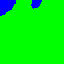

---------------------------
Mean Average Accutacy: tensor(0.8837) Mean IOU: tensor(0.7040)


<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [37]:
running_acc = 0.0
running_iou = 0.0
SMOOTH = 1e-6
device = 'cuda'
# Load the model for inference
model = Load_model(checkpoint_path)
# iteration over all the test images
for idx, item in enumerate(test_dl):
  image = item[0].to(device)
  label = item[1]
  rgb_image = item[2].to(device)
  # print(item[0].shape,item[1].shape,item[2].shape)
  # break

  one_hot_label = one_hot_encoding(label.numpy())
  label = label.to(device)
  output = model(image)
  output = torch.argmax(output, dim=1)
  
  output_for_metrics = torch.Tensor(one_hot_encoding(output.detach().cpu().numpy())).int()
  label_for_metrics = torch.tensor(one_hot_label)

  # accuaracy metric
  acc = accuracy(output_for_metrics, label_for_metrics)
  running_acc += acc

  # iou metric
  iou = iou_matrix(output_for_metrics, label_for_metrics)
  running_iou += iou

  # Visualization of every 5th image from the test sample
  if idx % 5 == 0:
    fig = plt.figure(figsize=(10, 7))
    image = torch.transpose(image[0], 0, 2).cpu().numpy()

    output = output[0].detach().cpu().numpy()
    output = labelVisualize(3, color_dict, output)

    label = label[0].cpu().numpy()  
    label = labelVisualize(3, color_dict, label)

    # cv2.imwrite(results_image_path+'res'+str(idx)+'_image.png',rgb_image)
    cv2.imwrite(results_image_path+'res'+str(idx)+'_label.png',label)
    cv2.imwrite(results_image_path+'res'+str(idx)+'_output.png',output)
    # print("Image")
    # cv2_imshow(rgb_image)
    print("Multi spectral image label")
    cv2_imshow(label)
    print("Multi spectral Network Output")
    cv2_imshow(output)
    print("---------------------------")
    if idx == 100:  # To visualize the results on the first few images from the test dataset
      break

mean_acc = running_acc / len(test_dl)  # Mean accuaracy
mean_iou = running_iou / len(test_dl)  # Mean IOU
print("Mean Average Accutacy: "+str(mean_acc)+" Mean IOU: "+str(mean_iou))